In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
# Custom color palette
palette = {
    "MYH7+_young": "#073E7F",
    "MYH7+_aged": "#83A0BE",
    "MYH2+_young": "#F49600",
    "MYH2+_aged": "#F9CB80",
    "MYH2⁺2+_young": "#866AA3",
    "MYH2⁺2+_aged": "#C1B7CF",
    "MYH1+_young": "#BE0E23",
    "MYH1+_aged": "#E18791"
}
color_before = palette["MYH7+_young"]
color_after = palette["MYH7+_aged"]
color_violin_0 = palette["MYH2+_young"]
color_violin_1 = palette["MYH2+_aged"]
color_fp_true = palette["MYH1+_young"]
color_fp_false = palette["MYH1+_aged"]

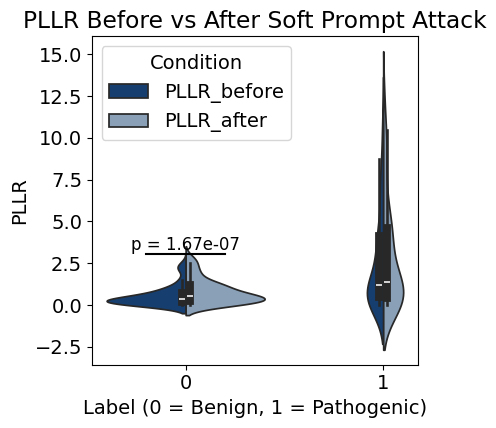

<ipython-input-9-eab0172a53fe>:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="label", y="delta_PLLR", data=df,


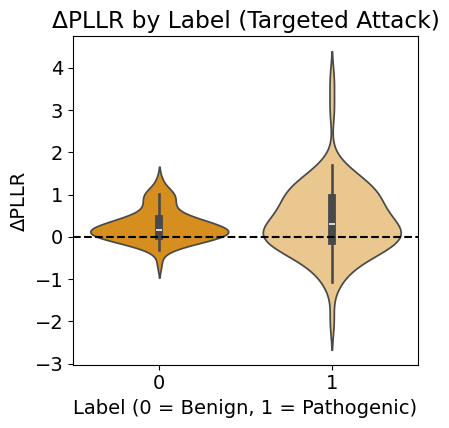

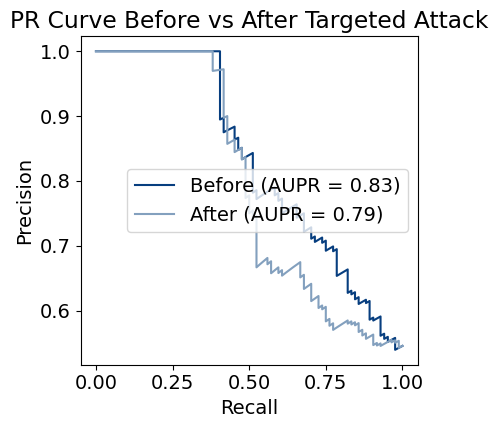

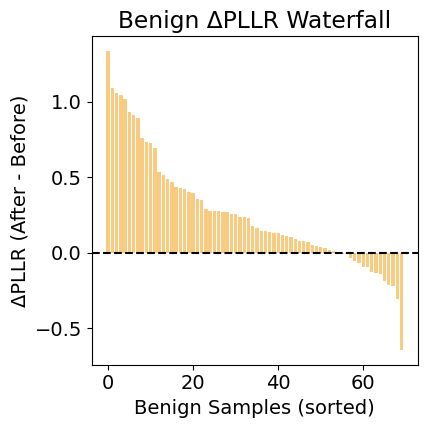

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve
from scipy.stats import ttest_rel

# File paths (update these if your filenames are different)
before_path = "/content/drive/My Drive/vep_FGSM/output_soft_prompt_confidence_1/callback_metrics/pllr_step_1.csv"
after_path = "/content/drive/My Drive/vep_FGSM/output_soft_prompt_confidence_1/callback_metrics/pllr_step_900.csv"

# Load PLLR data
df_before = pd.read_csv(before_path)
df_after = pd.read_csv(after_path)

# Rename columns and merge
df_before.columns = ["PLLR_before", "weighted_PLLR_before", "label"]
df_after.columns = ["PLLR_after", "weighted_PLLR_after", "label"]
df = df_before.copy()
df["PLLR_after"] = df_after["PLLR_after"]
df["weighted_PLLR_after"] = df_after["weighted_PLLR_after"]
df["delta_PLLR"] = df["PLLR_after"] - df["PLLR_before"]

# Threshold based on ROC
fpr, tpr, thresholds = roc_curve(df["label"], df["PLLR_before"])
j_scores = tpr - fpr
optimal_idx = j_scores.argmax()
threshold = thresholds[optimal_idx]

# Flip logic
df["pred_before"] = df["PLLR_before"] > threshold
df["pred_after"] = df["PLLR_after"] > threshold
df["flipped"] = (df["label"] == 0) & (df["pred_before"] == False) & (df["pred_after"] == True)

# Extract benign for focused analysis
df_benign = df[df["label"] == 0].copy()
df_benign_sorted = df_benign.sort_values(by="delta_PLLR", ascending=False).reset_index(drop=True)
cumulative_flips = np.cumsum(df_benign_sorted["flipped"].astype(int)) / len(df_benign_sorted)

# Prepare melted dataframe
df_melted = pd.melt(
    df,
    id_vars=["label"],
    value_vars=["PLLR_before", "PLLR_after"],
    var_name="Condition",
    value_name="PLLR"
)

# Set plot style
plt.rcParams.update({'font.size': 14})
FIGSIZE = (4.5, 4.5)


# 1. Violin plot: PLLR before vs after by label

# Paired t-test for benign variants (label == 0)
benign_before = df[df["label"] == 0]["PLLR_before"]
benign_after = df[df["label"] == 0]["PLLR_after"]
t_stat, p_val = ttest_rel(benign_before, benign_after)

plt.figure(figsize=FIGSIZE)
sns.violinplot(x="label", y="PLLR", hue="Condition", data=df_melted,
               palette=[color_before, color_after], split=True)
plt.title("PLLR Before vs After Soft Prompt Attack")
plt.xlabel("Label (0 = Benign, 1 = Pathogenic)")
plt.ylabel("PLLR")
#plt.text(x=0, y=max(benign_after) * 1.05, s=f"Benign p = {p_val:.2e}", fontsize=12)
# Annotate p-value visually for label == 0
y_max = max(df[df["label"] == 0][["PLLR_before", "PLLR_after"]].values.max(), 1.0)
y_pos = y_max * 1.05
x0, x1 = -0.2, 0.2  # label = 0 range
plt.plot([x0, x0, x1, x1], [y_pos, y_pos + 0.02, y_pos + 0.02, y_pos], lw=1.5, color='black')
plt.text(0, y_pos + 0.025, f"p = {p_val:.2e}", ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.savefig("/content/drive/My Drive/vep_FGSM/output/fig4_e_violin_pllr_by_label.png", dpi=300)
plt.show()

# 2. Violin plot: ΔPLLR by label
plt.figure(figsize=FIGSIZE)
sns.violinplot(x="label", y="delta_PLLR", data=df,
               palette=[color_violin_0, color_violin_1])
plt.axhline(0, color="black", linestyle="--")
plt.title("ΔPLLR by Label (Targeted Attack)")
plt.xlabel("Label (0 = Benign, 1 = Pathogenic)")
plt.ylabel("ΔPLLR")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/vep_FGSM/output/fig4_f_delta_pllr_by_label.png", dpi=300)
plt.show()

# 3. AUPR Curve
precision_before, recall_before, _ = precision_recall_curve(df["label"], df["PLLR_before"])
precision_after, recall_after, _ = precision_recall_curve(df["label"], df["PLLR_after"])
aupr_before = average_precision_score(df["label"], df["PLLR_before"])
aupr_after = average_precision_score(df["label"], df["PLLR_after"])

plt.figure(figsize=FIGSIZE)
plt.plot(recall_before, precision_before, color=color_before, label=f"Before (AUPR = {aupr_before:.2f})")
plt.plot(recall_after, precision_after, color=color_after, label=f"After (AUPR = {aupr_after:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve Before vs After Targeted Attack")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/My Drive/vep_FGSM/output/fig4_g_pr_curve_aupr.png", dpi=300)
plt.show()


# 5. Waterfall Plot
plt.figure(figsize=FIGSIZE)
plt.bar(np.arange(len(df_benign_sorted)), df_benign_sorted["delta_PLLR"], color=color_violin_1)
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("ΔPLLR (After - Before)")
plt.xlabel("Benign Samples (sorted)")
plt.title("Benign ΔPLLR Waterfall")
plt.tight_layout()
plt.savefig("/content/drive/My Drive/vep_FGSM/output/fig4_h_waterfall_delta_pllr.png", dpi=300)
plt.show()

